In [1]:
# Download and unzip
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzf cifar-10-python.tar.gz
!mkdir pixel_data

--2022-11-28 12:22:05--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Załadowano certyfikat CA '/etc/ssl/certs/ca-certificates.crt'
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Łączenie się z www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Zapis do: `cifar-10-python.tar.gz'

cifar-10-python.tar 100%[===================>] 162,60M   711KB/s     w 2m 49s  

2022-11-28 12:24:54 (987 KB/s) - zapisano `cifar-10-python.tar.gz' [170498071/170498071]



In [2]:
import pickle
import glob
import os

import numpy as np
from skimage.io import imsave


PIXELS_DIR = "pixel_data/"
LABEL_FILE = "labels.txt"


def unpack_file(fname):
    with open(fname, "rb") as f:
        result = pickle.load(f, encoding="bytes")
    return result


def save_as_image(img_flat, fname):
    # consecutive 1024 entries store color channels of 32x32 image
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))

    imsave(os.path.join(PIXELS_DIR, fname), img)

    
labels = {}

# use "data_batch_*" for just the training set
for fname in glob.glob("cifar-10-batches-py/*_batch*"):
    data = unpack_file(fname)

    for i in range(10000):
        img_flat = data[b"data"][i]
        fname = data[b"filenames"][i].decode()
        label = data[b"labels"][i]

        # save the image and store the label
        save_as_image(img_flat, fname)
        labels[fname] = label

# write out labels file
with open(LABEL_FILE, "w") as f:
    for (fname, label) in labels.items():
        f.write("{0} {1}\n".format(fname, label))

/tmp/ipykernel_5221/133430905.py:26: UserWarning: pixel_data/flying_bird_s_001061.png is a low contrast image
  imsave(os.path.join(PIXELS_DIR, fname), img)


In [3]:
import os

# folder path
dir_path = 'pixel_data'
# dir_path = 'images/val/class/'
# dir_path = 'images/train/class/'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 60000


In [4]:
# Move data into training and validation directories
import os
trainset = 'images/train/class/'
valset = 'images/val/class/'
os.makedirs(trainset, exist_ok=True) # 59,000 images
os.makedirs(valset, exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('pixel_data')):
  if i < 1000: # first 1000 will be val
    os.rename(PIXELS_DIR + file, valset + file)
  else: # others will be val
    os.rename(PIXELS_DIR + file, trainset + file)

In [5]:
# kaggle only
# !pwd
# !ls -la cifar-10-batches-py
# !ls -la images/val/class

# !zip -r checkpoints2.zip checkpoints
# !zip -r color2.zip outputs/color
# !zip -r gray2.zip outputs/gray
# !ls -la checkpoints
# !ls -la outputs/color
# !ls -la outputs/gray
# !rm checkpoints/*
# !rm outputs/color/*
# !rm outputs/gray/*

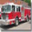

In [6]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename=valset+os.listdir(valset)[0]))

In [7]:
# Download and import libraries
# !pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1
!pip install torch torchvision 


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [9]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [10]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [11]:
model = ColorizationNet()

In [12]:
criterion = nn.MSELoss()

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [14]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [15]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [16]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [17]:
color_imgs = 'outputs/color/'
gray_imgs = 'outputs/gray/'

In [18]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': gray_imgs, 'colorized': color_imgs}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [19]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [20]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [21]:
# Make folders and set parameters
checkpoints = 'checkpoints'
os.makedirs(color_imgs, exist_ok=True)
os.makedirs(gray_imgs, exist_ok=True)
os.makedirs(checkpoints, exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 100

In [22]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), '{}/model-epoch-{}-losses-{:.3f}.pth'.format(checkpoints,epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/922]	Time 1.396 (1.396)	Data 0.447 (0.447)	Loss 0.3501 (0.3501)	
Epoch: [0][25/922]	Time 0.447 (0.479)	Data 0.407 (0.405)	Loss 0.0108 (0.0569)	
Epoch: [0][50/922]	Time 0.435 (0.458)	Data 0.397 (0.401)	Loss 0.0061 (0.0324)	
Epoch: [0][75/922]	Time 0.437 (0.450)	Data 0.399 (0.399)	Loss 0.0045 (0.0232)	
Epoch: [0][100/922]	Time 0.442 (0.448)	Data 0.402 (0.400)	Loss 0.0058 (0.0185)	
Epoch: [0][125/922]	Time 0.448 (0.446)	Data 0.410 (0.400)	Loss 0.0052 (0.0155)	
Epoch: [0][150/922]	Time 0.462 (0.446)	Data 0.424 (0.401)	Loss 0.0040 (0.0136)	
Epoch: [0][175/922]	Time 0.435 (0.445)	Data 0.397 (0.401)	Loss 0.0029 (0.0121)	
Epoch: [0][200/922]	Time 0.429 (0.444)	Data 0.390 (0.401)	Loss 0.0029 (0.0110)	
Epoch: [0][225/922]	Time 0.434 (0.443)	Data 0.396 (0.400)	Loss 0.0035 (0.0101)	
Epoch: [0][250/922]	Time 0.443 (0.443)	Data 0.403 (0.401)	Loss 0.0036 (0.0094)	
Epoch: [0][275/922]	Time 0.432 (0.443)	Data 0.394 (0.400)	Loss 0.0028 (0.0089)	
Epoch: [0][300/922]

Epoch: [2][625/922]	Time 0.431 (0.436)	Data 0.391 (0.396)	Loss 0.0026 (0.0027)	
Epoch: [2][650/922]	Time 0.431 (0.436)	Data 0.391 (0.396)	Loss 0.0022 (0.0027)	
Epoch: [2][675/922]	Time 0.437 (0.436)	Data 0.397 (0.396)	Loss 0.0031 (0.0027)	
Epoch: [2][700/922]	Time 0.434 (0.436)	Data 0.394 (0.396)	Loss 0.0024 (0.0027)	
Epoch: [2][725/922]	Time 0.437 (0.436)	Data 0.396 (0.396)	Loss 0.0027 (0.0027)	
Epoch: [2][750/922]	Time 0.445 (0.436)	Data 0.405 (0.396)	Loss 0.0026 (0.0027)	
Epoch: [2][775/922]	Time 0.434 (0.436)	Data 0.394 (0.396)	Loss 0.0030 (0.0027)	
Epoch: [2][800/922]	Time 0.432 (0.436)	Data 0.393 (0.396)	Loss 0.0028 (0.0027)	
Epoch: [2][825/922]	Time 0.439 (0.436)	Data 0.399 (0.397)	Loss 0.0027 (0.0027)	
Epoch: [2][850/922]	Time 0.439 (0.436)	Data 0.399 (0.397)	Loss 0.0029 (0.0027)	
Epoch: [2][875/922]	Time 0.442 (0.437)	Data 0.402 (0.397)	Loss 0.0029 (0.0027)	
Epoch: [2][900/922]	Time 0.445 (0.437)	Data 0.405 (0.397)	Loss 0.0029 (0.0027)	
Finished training epoch 2
Validate: [0/1

Epoch: [5][300/922]	Time 0.434 (0.438)	Data 0.395 (0.399)	Loss 0.0020 (0.0025)	
Epoch: [5][325/922]	Time 0.438 (0.439)	Data 0.400 (0.400)	Loss 0.0020 (0.0025)	
Epoch: [5][350/922]	Time 0.434 (0.439)	Data 0.394 (0.400)	Loss 0.0020 (0.0025)	
Epoch: [5][375/922]	Time 0.438 (0.439)	Data 0.399 (0.400)	Loss 0.0035 (0.0025)	
Epoch: [5][400/922]	Time 0.434 (0.439)	Data 0.394 (0.400)	Loss 0.0021 (0.0025)	
Epoch: [5][425/922]	Time 0.435 (0.439)	Data 0.397 (0.400)	Loss 0.0025 (0.0025)	
Epoch: [5][450/922]	Time 0.438 (0.439)	Data 0.399 (0.400)	Loss 0.0030 (0.0025)	
Epoch: [5][475/922]	Time 0.437 (0.439)	Data 0.399 (0.400)	Loss 0.0020 (0.0025)	
Epoch: [5][500/922]	Time 0.437 (0.439)	Data 0.397 (0.400)	Loss 0.0021 (0.0025)	
Epoch: [5][525/922]	Time 0.437 (0.439)	Data 0.399 (0.400)	Loss 0.0021 (0.0025)	
Epoch: [5][550/922]	Time 0.557 (0.440)	Data 0.518 (0.401)	Loss 0.0026 (0.0025)	
Epoch: [5][575/922]	Time 0.431 (0.439)	Data 0.391 (0.400)	Loss 0.0026 (0.0025)	
Epoch: [5][600/922]	Time 0.435 (0.439)	D

Validate: [0/16]	Time 0.510 (0.510)	Loss 0.0018 (0.0018)	
Finished validation.
Starting training epoch 8
Epoch: [8][0/922]	Time 0.440 (0.440)	Data 0.401 (0.401)	Loss 0.0022 (0.0022)	
Epoch: [8][25/922]	Time 0.445 (0.431)	Data 0.407 (0.393)	Loss 0.0028 (0.0026)	
Epoch: [8][50/922]	Time 0.433 (0.437)	Data 0.394 (0.399)	Loss 0.0020 (0.0026)	
Epoch: [8][75/922]	Time 0.436 (0.437)	Data 0.399 (0.399)	Loss 0.0023 (0.0025)	
Epoch: [8][100/922]	Time 0.428 (0.437)	Data 0.391 (0.399)	Loss 0.0022 (0.0025)	
Epoch: [8][125/922]	Time 0.430 (0.435)	Data 0.392 (0.397)	Loss 0.0027 (0.0025)	
Epoch: [8][150/922]	Time 0.428 (0.434)	Data 0.390 (0.396)	Loss 0.0026 (0.0025)	
Epoch: [8][175/922]	Time 0.428 (0.434)	Data 0.389 (0.396)	Loss 0.0020 (0.0025)	
Epoch: [8][200/922]	Time 0.433 (0.434)	Data 0.394 (0.396)	Loss 0.0024 (0.0025)	
Epoch: [8][225/922]	Time 0.433 (0.434)	Data 0.395 (0.396)	Loss 0.0022 (0.0025)	
Epoch: [8][250/922]	Time 0.431 (0.433)	Data 0.392 (0.395)	Loss 0.0022 (0.0025)	
Epoch: [8][275/922]	

Epoch: [10][600/922]	Time 0.432 (0.434)	Data 0.394 (0.396)	Loss 0.0028 (0.0024)	
Epoch: [10][625/922]	Time 0.434 (0.434)	Data 0.395 (0.396)	Loss 0.0021 (0.0024)	
Epoch: [10][650/922]	Time 0.432 (0.434)	Data 0.394 (0.396)	Loss 0.0026 (0.0024)	
Epoch: [10][675/922]	Time 0.435 (0.434)	Data 0.396 (0.396)	Loss 0.0021 (0.0024)	
Epoch: [10][700/922]	Time 0.442 (0.434)	Data 0.404 (0.396)	Loss 0.0025 (0.0024)	
Epoch: [10][725/922]	Time 0.432 (0.434)	Data 0.393 (0.396)	Loss 0.0028 (0.0024)	
Epoch: [10][750/922]	Time 0.437 (0.434)	Data 0.398 (0.396)	Loss 0.0024 (0.0024)	
Epoch: [10][775/922]	Time 0.435 (0.434)	Data 0.396 (0.396)	Loss 0.0017 (0.0024)	
Epoch: [10][800/922]	Time 0.432 (0.434)	Data 0.394 (0.396)	Loss 0.0020 (0.0024)	
Epoch: [10][825/922]	Time 0.434 (0.434)	Data 0.395 (0.396)	Loss 0.0026 (0.0024)	
Epoch: [10][850/922]	Time 0.437 (0.434)	Data 0.398 (0.396)	Loss 0.0025 (0.0024)	
Epoch: [10][875/922]	Time 0.435 (0.434)	Data 0.396 (0.396)	Loss 0.0021 (0.0024)	
Epoch: [10][900/922]	Time 0.

Epoch: [13][250/922]	Time 0.435 (0.433)	Data 0.395 (0.395)	Loss 0.0028 (0.0024)	
Epoch: [13][275/922]	Time 0.437 (0.434)	Data 0.397 (0.395)	Loss 0.0022 (0.0024)	
Epoch: [13][300/922]	Time 0.430 (0.434)	Data 0.392 (0.395)	Loss 0.0023 (0.0024)	
Epoch: [13][325/922]	Time 0.432 (0.434)	Data 0.394 (0.395)	Loss 0.0034 (0.0024)	
Epoch: [13][350/922]	Time 0.434 (0.434)	Data 0.397 (0.395)	Loss 0.0027 (0.0024)	
Epoch: [13][375/922]	Time 0.434 (0.434)	Data 0.395 (0.396)	Loss 0.0027 (0.0024)	
Epoch: [13][400/922]	Time 0.435 (0.434)	Data 0.397 (0.396)	Loss 0.0031 (0.0024)	
Epoch: [13][425/922]	Time 0.438 (0.435)	Data 0.399 (0.396)	Loss 0.0028 (0.0024)	
Epoch: [13][450/922]	Time 0.433 (0.435)	Data 0.394 (0.396)	Loss 0.0025 (0.0024)	
Epoch: [13][475/922]	Time 0.431 (0.435)	Data 0.393 (0.396)	Loss 0.0027 (0.0024)	
Epoch: [13][500/922]	Time 0.432 (0.435)	Data 0.392 (0.396)	Loss 0.0019 (0.0024)	
Epoch: [13][525/922]	Time 0.431 (0.435)	Data 0.393 (0.396)	Loss 0.0029 (0.0024)	
Epoch: [13][550/922]	Time 0.

Epoch: [15][850/922]	Time 0.431 (0.434)	Data 0.393 (0.396)	Loss 0.0020 (0.0024)	
Epoch: [15][875/922]	Time 0.437 (0.434)	Data 0.398 (0.396)	Loss 0.0021 (0.0024)	
Epoch: [15][900/922]	Time 0.439 (0.434)	Data 0.400 (0.396)	Loss 0.0032 (0.0024)	
Finished training epoch 15
Validate: [0/16]	Time 0.513 (0.513)	Loss 0.0020 (0.0020)	
Finished validation.
Starting training epoch 16
Epoch: [16][0/922]	Time 0.441 (0.441)	Data 0.401 (0.401)	Loss 0.0028 (0.0028)	
Epoch: [16][25/922]	Time 0.436 (0.438)	Data 0.397 (0.400)	Loss 0.0019 (0.0024)	
Epoch: [16][50/922]	Time 0.424 (0.434)	Data 0.386 (0.395)	Loss 0.0024 (0.0024)	
Epoch: [16][75/922]	Time 0.433 (0.436)	Data 0.394 (0.397)	Loss 0.0029 (0.0024)	
Epoch: [16][100/922]	Time 0.433 (0.435)	Data 0.395 (0.397)	Loss 0.0021 (0.0024)	
Epoch: [16][125/922]	Time 0.432 (0.435)	Data 0.395 (0.396)	Loss 0.0018 (0.0024)	
Epoch: [16][150/922]	Time 0.431 (0.435)	Data 0.393 (0.396)	Loss 0.0025 (0.0024)	
Epoch: [16][175/922]	Time 0.430 (0.434)	Data 0.392 (0.396)	Los

Epoch: [18][500/922]	Time 0.432 (0.434)	Data 0.392 (0.395)	Loss 0.0023 (0.0023)	
Epoch: [18][525/922]	Time 0.440 (0.434)	Data 0.402 (0.395)	Loss 0.0022 (0.0023)	
Epoch: [18][550/922]	Time 0.432 (0.434)	Data 0.393 (0.395)	Loss 0.0022 (0.0023)	
Epoch: [18][575/922]	Time 0.428 (0.434)	Data 0.389 (0.395)	Loss 0.0026 (0.0023)	
Epoch: [18][600/922]	Time 0.429 (0.433)	Data 0.391 (0.395)	Loss 0.0028 (0.0023)	
Epoch: [18][625/922]	Time 0.427 (0.433)	Data 0.389 (0.395)	Loss 0.0030 (0.0023)	
Epoch: [18][650/922]	Time 0.462 (0.433)	Data 0.422 (0.395)	Loss 0.0024 (0.0024)	
Epoch: [18][675/922]	Time 0.431 (0.433)	Data 0.391 (0.395)	Loss 0.0024 (0.0024)	
Epoch: [18][700/922]	Time 0.428 (0.433)	Data 0.389 (0.395)	Loss 0.0031 (0.0024)	
Epoch: [18][725/922]	Time 0.430 (0.433)	Data 0.391 (0.394)	Loss 0.0023 (0.0024)	
Epoch: [18][750/922]	Time 0.430 (0.433)	Data 0.392 (0.394)	Loss 0.0027 (0.0023)	
Epoch: [18][775/922]	Time 0.433 (0.433)	Data 0.393 (0.395)	Loss 0.0021 (0.0023)	
Epoch: [18][800/922]	Time 0.

Epoch: [21][150/922]	Time 0.434 (0.439)	Data 0.395 (0.400)	Loss 0.0029 (0.0024)	
Epoch: [21][175/922]	Time 0.434 (0.439)	Data 0.394 (0.400)	Loss 0.0020 (0.0024)	
Epoch: [21][200/922]	Time 0.437 (0.439)	Data 0.398 (0.400)	Loss 0.0025 (0.0024)	
Epoch: [21][225/922]	Time 0.433 (0.438)	Data 0.395 (0.399)	Loss 0.0022 (0.0024)	
Epoch: [21][250/922]	Time 0.438 (0.438)	Data 0.399 (0.399)	Loss 0.0025 (0.0024)	
Epoch: [21][275/922]	Time 0.439 (0.438)	Data 0.400 (0.399)	Loss 0.0028 (0.0024)	
Epoch: [21][300/922]	Time 0.431 (0.438)	Data 0.394 (0.399)	Loss 0.0030 (0.0024)	
Epoch: [21][325/922]	Time 0.436 (0.438)	Data 0.397 (0.399)	Loss 0.0023 (0.0024)	
Epoch: [21][350/922]	Time 0.438 (0.438)	Data 0.400 (0.399)	Loss 0.0029 (0.0024)	
Epoch: [21][375/922]	Time 0.439 (0.438)	Data 0.401 (0.400)	Loss 0.0024 (0.0024)	
Epoch: [21][400/922]	Time 0.436 (0.438)	Data 0.399 (0.400)	Loss 0.0028 (0.0024)	
Epoch: [21][425/922]	Time 0.436 (0.439)	Data 0.397 (0.400)	Loss 0.0021 (0.0024)	
Epoch: [21][450/922]	Time 0.

Epoch: [23][750/922]	Time 0.450 (0.435)	Data 0.410 (0.397)	Loss 0.0023 (0.0023)	
Epoch: [23][775/922]	Time 0.435 (0.435)	Data 0.395 (0.397)	Loss 0.0027 (0.0023)	
Epoch: [23][800/922]	Time 0.437 (0.435)	Data 0.399 (0.397)	Loss 0.0020 (0.0023)	
Epoch: [23][825/922]	Time 0.434 (0.435)	Data 0.396 (0.397)	Loss 0.0028 (0.0023)	
Epoch: [23][850/922]	Time 0.440 (0.435)	Data 0.401 (0.397)	Loss 0.0022 (0.0023)	
Epoch: [23][875/922]	Time 0.437 (0.436)	Data 0.398 (0.397)	Loss 0.0024 (0.0023)	
Epoch: [23][900/922]	Time 0.434 (0.436)	Data 0.395 (0.397)	Loss 0.0026 (0.0023)	
Finished training epoch 23
Validate: [0/16]	Time 0.508 (0.508)	Loss 0.0019 (0.0019)	
Finished validation.
Starting training epoch 24
Epoch: [24][0/922]	Time 0.447 (0.447)	Data 0.408 (0.408)	Loss 0.0022 (0.0022)	
Epoch: [24][25/922]	Time 0.445 (0.439)	Data 0.406 (0.400)	Loss 0.0024 (0.0024)	
Epoch: [24][50/922]	Time 0.440 (0.439)	Data 0.400 (0.400)	Loss 0.0025 (0.0023)	
Epoch: [24][75/922]	Time 0.438 (0.439)	Data 0.399 (0.400)	Los

Epoch: [26][400/922]	Time 0.434 (0.434)	Data 0.397 (0.396)	Loss 0.0022 (0.0023)	
Epoch: [26][425/922]	Time 0.433 (0.434)	Data 0.395 (0.396)	Loss 0.0024 (0.0023)	
Epoch: [26][450/922]	Time 0.430 (0.434)	Data 0.392 (0.396)	Loss 0.0025 (0.0023)	
Epoch: [26][475/922]	Time 0.429 (0.433)	Data 0.390 (0.396)	Loss 0.0020 (0.0023)	
Epoch: [26][500/922]	Time 0.431 (0.433)	Data 0.392 (0.395)	Loss 0.0020 (0.0023)	
Epoch: [26][525/922]	Time 0.434 (0.433)	Data 0.394 (0.395)	Loss 0.0027 (0.0023)	
Epoch: [26][550/922]	Time 0.429 (0.433)	Data 0.392 (0.395)	Loss 0.0017 (0.0023)	
Epoch: [26][575/922]	Time 0.430 (0.433)	Data 0.392 (0.395)	Loss 0.0019 (0.0023)	
Epoch: [26][600/922]	Time 0.433 (0.433)	Data 0.394 (0.395)	Loss 0.0022 (0.0023)	
Epoch: [26][625/922]	Time 0.432 (0.433)	Data 0.395 (0.395)	Loss 0.0027 (0.0023)	
Epoch: [26][650/922]	Time 0.429 (0.433)	Data 0.390 (0.395)	Loss 0.0023 (0.0023)	
Epoch: [26][675/922]	Time 0.432 (0.433)	Data 0.394 (0.395)	Loss 0.0021 (0.0023)	
Epoch: [26][700/922]	Time 0.

Epoch: [29][50/922]	Time 0.432 (0.437)	Data 0.392 (0.398)	Loss 0.0022 (0.0024)	
Epoch: [29][75/922]	Time 0.437 (0.437)	Data 0.398 (0.399)	Loss 0.0021 (0.0024)	
Epoch: [29][100/922]	Time 0.453 (0.439)	Data 0.415 (0.400)	Loss 0.0028 (0.0023)	
Epoch: [29][125/922]	Time 0.438 (0.438)	Data 0.399 (0.400)	Loss 0.0018 (0.0023)	
Epoch: [29][150/922]	Time 0.433 (0.438)	Data 0.394 (0.399)	Loss 0.0023 (0.0023)	
Epoch: [29][175/922]	Time 0.437 (0.438)	Data 0.399 (0.399)	Loss 0.0019 (0.0023)	
Epoch: [29][200/922]	Time 0.436 (0.437)	Data 0.398 (0.399)	Loss 0.0023 (0.0023)	
Epoch: [29][225/922]	Time 0.432 (0.437)	Data 0.393 (0.398)	Loss 0.0020 (0.0023)	
Epoch: [29][250/922]	Time 0.442 (0.436)	Data 0.404 (0.398)	Loss 0.0023 (0.0023)	
Epoch: [29][275/922]	Time 0.437 (0.436)	Data 0.398 (0.398)	Loss 0.0019 (0.0023)	
Epoch: [29][300/922]	Time 0.434 (0.437)	Data 0.397 (0.398)	Loss 0.0020 (0.0023)	
Epoch: [29][325/922]	Time 0.488 (0.437)	Data 0.450 (0.399)	Loss 0.0019 (0.0023)	
Epoch: [29][350/922]	Time 0.43

Epoch: [31][675/922]	Time 0.430 (0.435)	Data 0.391 (0.397)	Loss 0.0025 (0.0023)	
Epoch: [31][700/922]	Time 0.432 (0.435)	Data 0.394 (0.397)	Loss 0.0028 (0.0023)	
Epoch: [31][725/922]	Time 0.430 (0.435)	Data 0.393 (0.397)	Loss 0.0020 (0.0023)	
Epoch: [31][750/922]	Time 0.431 (0.435)	Data 0.392 (0.396)	Loss 0.0019 (0.0023)	
Epoch: [31][775/922]	Time 0.431 (0.434)	Data 0.393 (0.396)	Loss 0.0017 (0.0023)	
Epoch: [31][800/922]	Time 0.429 (0.434)	Data 0.391 (0.396)	Loss 0.0022 (0.0023)	
Epoch: [31][825/922]	Time 0.426 (0.434)	Data 0.388 (0.396)	Loss 0.0023 (0.0023)	
Epoch: [31][850/922]	Time 0.428 (0.434)	Data 0.389 (0.396)	Loss 0.0026 (0.0023)	
Epoch: [31][875/922]	Time 0.428 (0.434)	Data 0.391 (0.395)	Loss 0.0028 (0.0023)	
Epoch: [31][900/922]	Time 0.431 (0.434)	Data 0.393 (0.395)	Loss 0.0026 (0.0023)	
Finished training epoch 31
Validate: [0/16]	Time 0.522 (0.522)	Loss 0.0017 (0.0017)	
Finished validation.
Starting training epoch 32
Epoch: [32][0/922]	Time 0.444 (0.444)	Data 0.405 (0.405)	

Epoch: [34][325/922]	Time 0.428 (0.431)	Data 0.391 (0.392)	Loss 0.0018 (0.0023)	
Epoch: [34][350/922]	Time 0.426 (0.430)	Data 0.387 (0.392)	Loss 0.0020 (0.0023)	
Epoch: [34][375/922]	Time 0.428 (0.430)	Data 0.391 (0.392)	Loss 0.0023 (0.0023)	
Epoch: [34][400/922]	Time 0.432 (0.430)	Data 0.393 (0.392)	Loss 0.0023 (0.0023)	
Epoch: [34][425/922]	Time 0.431 (0.430)	Data 0.394 (0.392)	Loss 0.0020 (0.0023)	
Epoch: [34][450/922]	Time 0.428 (0.430)	Data 0.390 (0.392)	Loss 0.0030 (0.0023)	
Epoch: [34][475/922]	Time 0.436 (0.430)	Data 0.398 (0.392)	Loss 0.0017 (0.0023)	
Epoch: [34][500/922]	Time 0.435 (0.431)	Data 0.397 (0.393)	Loss 0.0025 (0.0023)	
Epoch: [34][525/922]	Time 0.439 (0.431)	Data 0.401 (0.393)	Loss 0.0022 (0.0023)	
Epoch: [34][550/922]	Time 0.442 (0.432)	Data 0.404 (0.394)	Loss 0.0018 (0.0023)	
Epoch: [34][575/922]	Time 0.442 (0.432)	Data 0.404 (0.394)	Loss 0.0024 (0.0023)	
Epoch: [34][600/922]	Time 0.447 (0.433)	Data 0.409 (0.394)	Loss 0.0019 (0.0023)	
Epoch: [34][625/922]	Time 0.

Finished training epoch 36
Validate: [0/16]	Time 0.510 (0.510)	Loss 0.0017 (0.0017)	
Finished validation.
Starting training epoch 37
Epoch: [37][0/922]	Time 0.439 (0.439)	Data 0.398 (0.398)	Loss 0.0022 (0.0022)	
Epoch: [37][25/922]	Time 0.435 (0.436)	Data 0.396 (0.396)	Loss 0.0017 (0.0022)	
Epoch: [37][50/922]	Time 0.436 (0.436)	Data 0.396 (0.397)	Loss 0.0020 (0.0023)	
Epoch: [37][75/922]	Time 0.438 (0.436)	Data 0.400 (0.397)	Loss 0.0025 (0.0023)	
Epoch: [37][100/922]	Time 0.436 (0.436)	Data 0.397 (0.397)	Loss 0.0025 (0.0023)	
Epoch: [37][125/922]	Time 0.432 (0.436)	Data 0.395 (0.397)	Loss 0.0027 (0.0023)	
Epoch: [37][150/922]	Time 0.436 (0.436)	Data 0.398 (0.397)	Loss 0.0021 (0.0023)	
Epoch: [37][175/922]	Time 0.432 (0.436)	Data 0.394 (0.397)	Loss 0.0026 (0.0023)	
Epoch: [37][200/922]	Time 0.441 (0.436)	Data 0.402 (0.398)	Loss 0.0021 (0.0023)	
Epoch: [37][225/922]	Time 0.448 (0.437)	Data 0.409 (0.398)	Loss 0.0026 (0.0023)	
Epoch: [37][250/922]	Time 0.437 (0.437)	Data 0.399 (0.399)	Los

Epoch: [39][575/922]	Time 0.433 (0.434)	Data 0.395 (0.396)	Loss 0.0021 (0.0023)	
Epoch: [39][600/922]	Time 0.436 (0.435)	Data 0.398 (0.396)	Loss 0.0017 (0.0023)	
Epoch: [39][625/922]	Time 0.468 (0.435)	Data 0.429 (0.397)	Loss 0.0018 (0.0023)	
Epoch: [39][650/922]	Time 0.441 (0.435)	Data 0.404 (0.397)	Loss 0.0021 (0.0023)	
Epoch: [39][675/922]	Time 0.437 (0.435)	Data 0.397 (0.397)	Loss 0.0024 (0.0023)	
Epoch: [39][700/922]	Time 0.437 (0.436)	Data 0.399 (0.397)	Loss 0.0024 (0.0023)	
Epoch: [39][725/922]	Time 0.440 (0.436)	Data 0.401 (0.397)	Loss 0.0022 (0.0023)	
Epoch: [39][750/922]	Time 0.427 (0.436)	Data 0.388 (0.397)	Loss 0.0023 (0.0023)	
Epoch: [39][775/922]	Time 0.446 (0.436)	Data 0.407 (0.398)	Loss 0.0026 (0.0023)	
Epoch: [39][800/922]	Time 0.436 (0.436)	Data 0.397 (0.398)	Loss 0.0024 (0.0023)	
Epoch: [39][825/922]	Time 0.435 (0.436)	Data 0.396 (0.398)	Loss 0.0024 (0.0023)	
Epoch: [39][850/922]	Time 0.432 (0.436)	Data 0.395 (0.398)	Loss 0.0022 (0.0023)	
Epoch: [39][875/922]	Time 0.

Epoch: [42][225/922]	Time 0.427 (0.435)	Data 0.390 (0.396)	Loss 0.0022 (0.0023)	
Epoch: [42][250/922]	Time 0.430 (0.435)	Data 0.393 (0.396)	Loss 0.0022 (0.0023)	
Epoch: [42][275/922]	Time 0.490 (0.435)	Data 0.452 (0.396)	Loss 0.0024 (0.0023)	
Epoch: [42][300/922]	Time 0.432 (0.435)	Data 0.393 (0.397)	Loss 0.0024 (0.0023)	
Epoch: [42][325/922]	Time 0.429 (0.435)	Data 0.391 (0.396)	Loss 0.0024 (0.0023)	
Epoch: [42][350/922]	Time 0.428 (0.435)	Data 0.389 (0.396)	Loss 0.0025 (0.0023)	
Epoch: [42][375/922]	Time 0.438 (0.435)	Data 0.399 (0.396)	Loss 0.0017 (0.0023)	
Epoch: [42][400/922]	Time 0.436 (0.435)	Data 0.397 (0.396)	Loss 0.0020 (0.0023)	
Epoch: [42][425/922]	Time 0.434 (0.435)	Data 0.396 (0.397)	Loss 0.0020 (0.0023)	
Epoch: [42][450/922]	Time 0.431 (0.436)	Data 0.392 (0.397)	Loss 0.0024 (0.0023)	
Epoch: [42][475/922]	Time 0.434 (0.436)	Data 0.395 (0.397)	Loss 0.0025 (0.0023)	
Epoch: [42][500/922]	Time 0.434 (0.436)	Data 0.395 (0.397)	Loss 0.0019 (0.0023)	
Epoch: [42][525/922]	Time 0.

Epoch: [44][825/922]	Time 0.428 (0.432)	Data 0.391 (0.394)	Loss 0.0024 (0.0023)	
Epoch: [44][850/922]	Time 0.427 (0.432)	Data 0.389 (0.394)	Loss 0.0024 (0.0023)	
Epoch: [44][875/922]	Time 0.439 (0.432)	Data 0.401 (0.394)	Loss 0.0020 (0.0023)	
Epoch: [44][900/922]	Time 0.434 (0.432)	Data 0.396 (0.394)	Loss 0.0025 (0.0023)	
Finished training epoch 44
Validate: [0/16]	Time 0.506 (0.506)	Loss 0.0017 (0.0017)	
Finished validation.
Starting training epoch 45
Epoch: [45][0/922]	Time 0.430 (0.430)	Data 0.391 (0.391)	Loss 0.0024 (0.0024)	
Epoch: [45][25/922]	Time 0.432 (0.428)	Data 0.393 (0.390)	Loss 0.0020 (0.0022)	
Epoch: [45][50/922]	Time 0.427 (0.428)	Data 0.389 (0.390)	Loss 0.0022 (0.0022)	
Epoch: [45][75/922]	Time 0.428 (0.429)	Data 0.391 (0.391)	Loss 0.0024 (0.0023)	
Epoch: [45][100/922]	Time 0.428 (0.428)	Data 0.389 (0.390)	Loss 0.0026 (0.0023)	
Epoch: [45][125/922]	Time 0.430 (0.428)	Data 0.392 (0.390)	Loss 0.0019 (0.0023)	
Epoch: [45][150/922]	Time 0.428 (0.428)	Data 0.390 (0.390)	Los

Epoch: [47][475/922]	Time 0.434 (0.434)	Data 0.397 (0.396)	Loss 0.0024 (0.0023)	
Epoch: [47][500/922]	Time 0.435 (0.434)	Data 0.397 (0.396)	Loss 0.0022 (0.0023)	
Epoch: [47][525/922]	Time 0.432 (0.434)	Data 0.394 (0.396)	Loss 0.0020 (0.0023)	
Epoch: [47][550/922]	Time 0.428 (0.434)	Data 0.391 (0.396)	Loss 0.0031 (0.0023)	
Epoch: [47][575/922]	Time 0.434 (0.434)	Data 0.396 (0.396)	Loss 0.0028 (0.0023)	
Epoch: [47][600/922]	Time 0.437 (0.434)	Data 0.398 (0.396)	Loss 0.0019 (0.0023)	
Epoch: [47][625/922]	Time 0.438 (0.434)	Data 0.400 (0.396)	Loss 0.0023 (0.0023)	
Epoch: [47][650/922]	Time 0.431 (0.434)	Data 0.392 (0.396)	Loss 0.0023 (0.0023)	
Epoch: [47][675/922]	Time 0.432 (0.434)	Data 0.393 (0.396)	Loss 0.0021 (0.0023)	
Epoch: [47][700/922]	Time 0.435 (0.434)	Data 0.395 (0.396)	Loss 0.0024 (0.0023)	
Epoch: [47][725/922]	Time 0.432 (0.434)	Data 0.393 (0.396)	Loss 0.0022 (0.0023)	
Epoch: [47][750/922]	Time 0.433 (0.434)	Data 0.395 (0.396)	Loss 0.0023 (0.0023)	
Epoch: [47][775/922]	Time 0.

Epoch: [50][125/922]	Time 0.434 (0.435)	Data 0.395 (0.397)	Loss 0.0022 (0.0023)	
Epoch: [50][150/922]	Time 0.431 (0.435)	Data 0.392 (0.396)	Loss 0.0023 (0.0023)	
Epoch: [50][175/922]	Time 0.431 (0.434)	Data 0.393 (0.396)	Loss 0.0020 (0.0023)	
Epoch: [50][200/922]	Time 0.430 (0.434)	Data 0.393 (0.395)	Loss 0.0022 (0.0023)	
Epoch: [50][225/922]	Time 0.428 (0.433)	Data 0.391 (0.395)	Loss 0.0028 (0.0023)	
Epoch: [50][250/922]	Time 0.442 (0.433)	Data 0.402 (0.395)	Loss 0.0022 (0.0023)	
Epoch: [50][275/922]	Time 0.430 (0.433)	Data 0.392 (0.395)	Loss 0.0021 (0.0023)	
Epoch: [50][300/922]	Time 0.431 (0.433)	Data 0.392 (0.395)	Loss 0.0024 (0.0023)	
Epoch: [50][325/922]	Time 0.437 (0.433)	Data 0.399 (0.395)	Loss 0.0021 (0.0023)	
Epoch: [50][350/922]	Time 0.430 (0.433)	Data 0.392 (0.395)	Loss 0.0022 (0.0023)	
Epoch: [50][375/922]	Time 0.430 (0.433)	Data 0.392 (0.395)	Loss 0.0019 (0.0023)	
Epoch: [50][400/922]	Time 0.434 (0.433)	Data 0.396 (0.395)	Loss 0.0024 (0.0023)	
Epoch: [50][425/922]	Time 0.

Epoch: [52][725/922]	Time 0.431 (0.432)	Data 0.392 (0.393)	Loss 0.0019 (0.0023)	
Epoch: [52][750/922]	Time 0.437 (0.432)	Data 0.398 (0.393)	Loss 0.0022 (0.0023)	
Epoch: [52][775/922]	Time 0.432 (0.432)	Data 0.393 (0.393)	Loss 0.0020 (0.0023)	
Epoch: [52][800/922]	Time 0.443 (0.432)	Data 0.404 (0.393)	Loss 0.0016 (0.0023)	
Epoch: [52][825/922]	Time 0.432 (0.432)	Data 0.393 (0.394)	Loss 0.0026 (0.0023)	
Epoch: [52][850/922]	Time 0.433 (0.432)	Data 0.394 (0.394)	Loss 0.0020 (0.0023)	
Epoch: [52][875/922]	Time 0.430 (0.432)	Data 0.391 (0.394)	Loss 0.0019 (0.0023)	
Epoch: [52][900/922]	Time 0.437 (0.433)	Data 0.399 (0.394)	Loss 0.0019 (0.0023)	
Finished training epoch 52
Validate: [0/16]	Time 0.515 (0.515)	Loss 0.0016 (0.0016)	
Finished validation.
Starting training epoch 53
Epoch: [53][0/922]	Time 0.439 (0.439)	Data 0.400 (0.400)	Loss 0.0033 (0.0033)	
Epoch: [53][25/922]	Time 0.432 (0.435)	Data 0.393 (0.396)	Loss 0.0032 (0.0024)	
Epoch: [53][50/922]	Time 0.431 (0.437)	Data 0.392 (0.398)	Lo

Epoch: [55][375/922]	Time 0.429 (0.435)	Data 0.391 (0.397)	Loss 0.0028 (0.0023)	
Epoch: [55][400/922]	Time 0.429 (0.435)	Data 0.391 (0.396)	Loss 0.0025 (0.0023)	
Epoch: [55][425/922]	Time 0.438 (0.435)	Data 0.399 (0.396)	Loss 0.0020 (0.0023)	
Epoch: [55][450/922]	Time 0.434 (0.435)	Data 0.396 (0.396)	Loss 0.0023 (0.0023)	
Epoch: [55][475/922]	Time 0.442 (0.435)	Data 0.404 (0.396)	Loss 0.0018 (0.0023)	
Epoch: [55][500/922]	Time 0.438 (0.435)	Data 0.400 (0.397)	Loss 0.0027 (0.0023)	
Epoch: [55][525/922]	Time 0.433 (0.435)	Data 0.395 (0.397)	Loss 0.0028 (0.0023)	
Epoch: [55][550/922]	Time 0.445 (0.435)	Data 0.405 (0.397)	Loss 0.0020 (0.0023)	
Epoch: [55][575/922]	Time 0.444 (0.435)	Data 0.406 (0.397)	Loss 0.0025 (0.0023)	
Epoch: [55][600/922]	Time 0.442 (0.436)	Data 0.404 (0.397)	Loss 0.0023 (0.0023)	
Epoch: [55][625/922]	Time 0.430 (0.435)	Data 0.390 (0.397)	Loss 0.0027 (0.0023)	
Epoch: [55][650/922]	Time 0.426 (0.435)	Data 0.387 (0.397)	Loss 0.0024 (0.0023)	
Epoch: [55][675/922]	Time 0.

Epoch: [58][25/922]	Time 0.433 (0.434)	Data 0.394 (0.395)	Loss 0.0027 (0.0023)	
Epoch: [58][50/922]	Time 0.428 (0.434)	Data 0.389 (0.395)	Loss 0.0024 (0.0024)	
Epoch: [58][75/922]	Time 0.430 (0.434)	Data 0.391 (0.395)	Loss 0.0023 (0.0024)	
Epoch: [58][100/922]	Time 0.427 (0.433)	Data 0.389 (0.394)	Loss 0.0021 (0.0024)	
Epoch: [58][125/922]	Time 0.433 (0.433)	Data 0.394 (0.394)	Loss 0.0025 (0.0024)	
Epoch: [58][150/922]	Time 0.428 (0.432)	Data 0.390 (0.393)	Loss 0.0024 (0.0023)	
Epoch: [58][175/922]	Time 0.446 (0.432)	Data 0.407 (0.393)	Loss 0.0029 (0.0023)	
Epoch: [58][200/922]	Time 0.432 (0.432)	Data 0.393 (0.393)	Loss 0.0024 (0.0023)	
Epoch: [58][225/922]	Time 0.438 (0.433)	Data 0.399 (0.394)	Loss 0.0019 (0.0023)	
Epoch: [58][250/922]	Time 0.434 (0.434)	Data 0.395 (0.395)	Loss 0.0017 (0.0023)	
Epoch: [58][275/922]	Time 0.432 (0.434)	Data 0.393 (0.395)	Loss 0.0023 (0.0023)	
Epoch: [58][300/922]	Time 0.433 (0.434)	Data 0.394 (0.395)	Loss 0.0024 (0.0023)	
Epoch: [58][325/922]	Time 0.433

Epoch: [60][650/922]	Time 0.433 (0.436)	Data 0.394 (0.397)	Loss 0.0027 (0.0023)	
Epoch: [60][675/922]	Time 0.437 (0.436)	Data 0.398 (0.397)	Loss 0.0020 (0.0023)	
Epoch: [60][700/922]	Time 0.433 (0.436)	Data 0.395 (0.397)	Loss 0.0021 (0.0023)	
Epoch: [60][725/922]	Time 0.435 (0.436)	Data 0.395 (0.397)	Loss 0.0025 (0.0023)	
Epoch: [60][750/922]	Time 0.443 (0.436)	Data 0.403 (0.397)	Loss 0.0035 (0.0023)	
Epoch: [60][775/922]	Time 0.435 (0.436)	Data 0.397 (0.397)	Loss 0.0025 (0.0023)	
Epoch: [60][800/922]	Time 0.440 (0.436)	Data 0.400 (0.397)	Loss 0.0015 (0.0023)	
Epoch: [60][825/922]	Time 0.438 (0.436)	Data 0.400 (0.397)	Loss 0.0021 (0.0023)	
Epoch: [60][850/922]	Time 0.433 (0.436)	Data 0.395 (0.397)	Loss 0.0022 (0.0023)	
Epoch: [60][875/922]	Time 0.429 (0.436)	Data 0.391 (0.397)	Loss 0.0022 (0.0023)	
Epoch: [60][900/922]	Time 0.433 (0.436)	Data 0.395 (0.397)	Loss 0.0021 (0.0023)	
Finished training epoch 60
Validate: [0/16]	Time 0.513 (0.513)	Loss 0.0016 (0.0016)	
Finished validation.
Sta

Epoch: [63][300/922]	Time 0.428 (0.431)	Data 0.390 (0.393)	Loss 0.0022 (0.0023)	
Epoch: [63][325/922]	Time 0.429 (0.431)	Data 0.391 (0.393)	Loss 0.0024 (0.0023)	
Epoch: [63][350/922]	Time 0.424 (0.431)	Data 0.386 (0.393)	Loss 0.0024 (0.0023)	
Epoch: [63][375/922]	Time 0.428 (0.431)	Data 0.390 (0.392)	Loss 0.0023 (0.0023)	
Epoch: [63][400/922]	Time 0.453 (0.431)	Data 0.415 (0.392)	Loss 0.0021 (0.0023)	
Epoch: [63][425/922]	Time 0.425 (0.431)	Data 0.386 (0.393)	Loss 0.0027 (0.0023)	
Epoch: [63][450/922]	Time 0.424 (0.431)	Data 0.386 (0.393)	Loss 0.0025 (0.0023)	
Epoch: [63][475/922]	Time 0.429 (0.431)	Data 0.392 (0.392)	Loss 0.0027 (0.0023)	
Epoch: [63][500/922]	Time 0.432 (0.431)	Data 0.393 (0.393)	Loss 0.0025 (0.0023)	
Epoch: [63][525/922]	Time 0.436 (0.431)	Data 0.397 (0.393)	Loss 0.0022 (0.0023)	
Epoch: [63][550/922]	Time 0.446 (0.431)	Data 0.407 (0.393)	Loss 0.0028 (0.0023)	
Epoch: [63][575/922]	Time 0.432 (0.432)	Data 0.394 (0.393)	Loss 0.0023 (0.0023)	
Epoch: [63][600/922]	Time 0.

Epoch: [65][900/922]	Time 0.436 (0.439)	Data 0.398 (0.401)	Loss 0.0025 (0.0023)	
Finished training epoch 65
Validate: [0/16]	Time 0.510 (0.510)	Loss 0.0016 (0.0016)	
Finished validation.
Starting training epoch 66
Epoch: [66][0/922]	Time 0.457 (0.457)	Data 0.416 (0.416)	Loss 0.0028 (0.0028)	
Epoch: [66][25/922]	Time 0.440 (0.438)	Data 0.402 (0.400)	Loss 0.0023 (0.0024)	
Epoch: [66][50/922]	Time 0.440 (0.439)	Data 0.402 (0.401)	Loss 0.0025 (0.0024)	
Epoch: [66][75/922]	Time 0.444 (0.440)	Data 0.406 (0.401)	Loss 0.0024 (0.0024)	
Epoch: [66][100/922]	Time 0.438 (0.440)	Data 0.400 (0.402)	Loss 0.0021 (0.0023)	
Epoch: [66][125/922]	Time 0.440 (0.440)	Data 0.400 (0.402)	Loss 0.0025 (0.0023)	
Epoch: [66][150/922]	Time 0.439 (0.439)	Data 0.399 (0.401)	Loss 0.0025 (0.0023)	
Epoch: [66][175/922]	Time 0.435 (0.439)	Data 0.397 (0.401)	Loss 0.0025 (0.0023)	
Epoch: [66][200/922]	Time 0.437 (0.438)	Data 0.399 (0.400)	Loss 0.0017 (0.0023)	
Epoch: [66][225/922]	Time 0.432 (0.438)	Data 0.394 (0.400)	Los

Epoch: [68][550/922]	Time 0.432 (0.432)	Data 0.395 (0.394)	Loss 0.0019 (0.0022)	
Epoch: [68][575/922]	Time 0.429 (0.432)	Data 0.391 (0.394)	Loss 0.0020 (0.0022)	
Epoch: [68][600/922]	Time 0.426 (0.433)	Data 0.388 (0.395)	Loss 0.0017 (0.0022)	
Epoch: [68][625/922]	Time 0.432 (0.433)	Data 0.393 (0.395)	Loss 0.0024 (0.0022)	
Epoch: [68][650/922]	Time 0.434 (0.433)	Data 0.395 (0.395)	Loss 0.0025 (0.0022)	
Epoch: [68][675/922]	Time 0.436 (0.433)	Data 0.397 (0.395)	Loss 0.0019 (0.0022)	
Epoch: [68][700/922]	Time 0.438 (0.433)	Data 0.399 (0.395)	Loss 0.0024 (0.0023)	
Epoch: [68][725/922]	Time 0.437 (0.433)	Data 0.398 (0.395)	Loss 0.0024 (0.0023)	
Epoch: [68][750/922]	Time 0.431 (0.433)	Data 0.393 (0.395)	Loss 0.0021 (0.0023)	
Epoch: [68][775/922]	Time 0.438 (0.433)	Data 0.399 (0.395)	Loss 0.0022 (0.0023)	
Epoch: [68][800/922]	Time 0.443 (0.434)	Data 0.404 (0.395)	Loss 0.0031 (0.0023)	
Epoch: [68][825/922]	Time 0.436 (0.434)	Data 0.396 (0.396)	Loss 0.0022 (0.0023)	
Epoch: [68][850/922]	Time 0.

Epoch: [71][200/922]	Time 0.431 (0.431)	Data 0.392 (0.393)	Loss 0.0018 (0.0023)	
Epoch: [71][225/922]	Time 0.431 (0.431)	Data 0.392 (0.393)	Loss 0.0021 (0.0023)	
Epoch: [71][250/922]	Time 0.430 (0.431)	Data 0.392 (0.393)	Loss 0.0026 (0.0023)	
Epoch: [71][275/922]	Time 0.435 (0.431)	Data 0.396 (0.393)	Loss 0.0022 (0.0023)	
Epoch: [71][300/922]	Time 0.429 (0.431)	Data 0.390 (0.392)	Loss 0.0026 (0.0023)	
Epoch: [71][325/922]	Time 0.428 (0.431)	Data 0.390 (0.392)	Loss 0.0023 (0.0023)	
Epoch: [71][350/922]	Time 0.426 (0.431)	Data 0.387 (0.392)	Loss 0.0019 (0.0023)	
Epoch: [71][375/922]	Time 0.425 (0.430)	Data 0.387 (0.392)	Loss 0.0024 (0.0023)	
Epoch: [71][400/922]	Time 0.425 (0.430)	Data 0.388 (0.391)	Loss 0.0017 (0.0023)	
Epoch: [71][425/922]	Time 0.425 (0.430)	Data 0.385 (0.391)	Loss 0.0020 (0.0023)	
Epoch: [71][450/922]	Time 0.425 (0.430)	Data 0.388 (0.391)	Loss 0.0026 (0.0023)	
Epoch: [71][475/922]	Time 0.427 (0.430)	Data 0.390 (0.391)	Loss 0.0025 (0.0023)	
Epoch: [71][500/922]	Time 0.

Epoch: [73][800/922]	Time 0.431 (0.433)	Data 0.393 (0.395)	Loss 0.0024 (0.0023)	
Epoch: [73][825/922]	Time 0.436 (0.433)	Data 0.397 (0.395)	Loss 0.0024 (0.0023)	
Epoch: [73][850/922]	Time 0.429 (0.433)	Data 0.391 (0.395)	Loss 0.0027 (0.0023)	
Epoch: [73][875/922]	Time 0.429 (0.433)	Data 0.391 (0.395)	Loss 0.0029 (0.0023)	
Epoch: [73][900/922]	Time 0.433 (0.433)	Data 0.395 (0.395)	Loss 0.0020 (0.0023)	
Finished training epoch 73
Validate: [0/16]	Time 0.519 (0.519)	Loss 0.0017 (0.0017)	
Finished validation.
Starting training epoch 74
Epoch: [74][0/922]	Time 0.444 (0.444)	Data 0.405 (0.405)	Loss 0.0029 (0.0029)	
Epoch: [74][25/922]	Time 0.437 (0.438)	Data 0.399 (0.400)	Loss 0.0019 (0.0025)	
Epoch: [74][50/922]	Time 0.439 (0.438)	Data 0.401 (0.400)	Loss 0.0018 (0.0024)	
Epoch: [74][75/922]	Time 0.430 (0.437)	Data 0.391 (0.399)	Loss 0.0025 (0.0024)	
Epoch: [74][100/922]	Time 0.489 (0.438)	Data 0.452 (0.400)	Loss 0.0017 (0.0023)	
Epoch: [74][125/922]	Time 0.443 (0.438)	Data 0.405 (0.400)	Los

Epoch: [76][450/922]	Time 0.432 (0.438)	Data 0.394 (0.399)	Loss 0.0025 (0.0023)	
Epoch: [76][475/922]	Time 0.433 (0.437)	Data 0.394 (0.399)	Loss 0.0020 (0.0023)	
Epoch: [76][500/922]	Time 0.436 (0.437)	Data 0.396 (0.399)	Loss 0.0024 (0.0023)	
Epoch: [76][525/922]	Time 0.437 (0.437)	Data 0.398 (0.399)	Loss 0.0019 (0.0023)	
Epoch: [76][550/922]	Time 0.433 (0.437)	Data 0.393 (0.399)	Loss 0.0021 (0.0023)	
Epoch: [76][575/922]	Time 0.437 (0.437)	Data 0.398 (0.399)	Loss 0.0018 (0.0023)	
Epoch: [76][600/922]	Time 0.436 (0.437)	Data 0.396 (0.398)	Loss 0.0020 (0.0023)	
Epoch: [76][625/922]	Time 0.438 (0.437)	Data 0.399 (0.398)	Loss 0.0021 (0.0023)	
Epoch: [76][650/922]	Time 0.436 (0.437)	Data 0.397 (0.398)	Loss 0.0022 (0.0023)	
Epoch: [76][675/922]	Time 0.428 (0.437)	Data 0.389 (0.398)	Loss 0.0022 (0.0023)	
Epoch: [76][700/922]	Time 0.438 (0.437)	Data 0.399 (0.398)	Loss 0.0024 (0.0023)	
Epoch: [76][725/922]	Time 0.434 (0.437)	Data 0.393 (0.398)	Loss 0.0022 (0.0023)	
Epoch: [76][750/922]	Time 0.

Epoch: [79][100/922]	Time 0.430 (0.434)	Data 0.392 (0.396)	Loss 0.0025 (0.0024)	
Epoch: [79][125/922]	Time 0.431 (0.434)	Data 0.393 (0.396)	Loss 0.0028 (0.0024)	
Epoch: [79][150/922]	Time 0.432 (0.434)	Data 0.394 (0.396)	Loss 0.0024 (0.0024)	
Epoch: [79][175/922]	Time 0.433 (0.434)	Data 0.396 (0.396)	Loss 0.0018 (0.0024)	
Epoch: [79][200/922]	Time 0.432 (0.434)	Data 0.395 (0.396)	Loss 0.0029 (0.0024)	
Epoch: [79][225/922]	Time 0.432 (0.434)	Data 0.394 (0.395)	Loss 0.0025 (0.0024)	
Epoch: [79][250/922]	Time 0.432 (0.433)	Data 0.395 (0.395)	Loss 0.0023 (0.0024)	
Epoch: [79][275/922]	Time 0.434 (0.433)	Data 0.396 (0.395)	Loss 0.0020 (0.0024)	
Epoch: [79][300/922]	Time 0.432 (0.433)	Data 0.395 (0.395)	Loss 0.0023 (0.0024)	
Epoch: [79][325/922]	Time 0.431 (0.433)	Data 0.392 (0.395)	Loss 0.0022 (0.0024)	
Epoch: [79][350/922]	Time 0.431 (0.433)	Data 0.393 (0.395)	Loss 0.0026 (0.0024)	
Epoch: [79][375/922]	Time 0.447 (0.433)	Data 0.409 (0.395)	Loss 0.0021 (0.0024)	
Epoch: [79][400/922]	Time 0.

Epoch: [81][700/922]	Time 0.427 (0.434)	Data 0.389 (0.395)	Loss 0.0024 (0.0024)	
Epoch: [81][725/922]	Time 0.428 (0.433)	Data 0.391 (0.395)	Loss 0.0030 (0.0024)	
Epoch: [81][750/922]	Time 0.432 (0.433)	Data 0.395 (0.395)	Loss 0.0026 (0.0024)	
Epoch: [81][775/922]	Time 0.424 (0.433)	Data 0.386 (0.395)	Loss 0.0029 (0.0024)	
Epoch: [81][800/922]	Time 0.429 (0.433)	Data 0.390 (0.395)	Loss 0.0020 (0.0024)	
Epoch: [81][825/922]	Time 0.435 (0.433)	Data 0.395 (0.395)	Loss 0.0029 (0.0024)	
Epoch: [81][850/922]	Time 0.439 (0.433)	Data 0.401 (0.395)	Loss 0.0025 (0.0024)	
Epoch: [81][875/922]	Time 0.430 (0.433)	Data 0.391 (0.395)	Loss 0.0024 (0.0024)	
Epoch: [81][900/922]	Time 0.429 (0.433)	Data 0.391 (0.395)	Loss 0.0023 (0.0024)	
Finished training epoch 81
Validate: [0/16]	Time 0.510 (0.510)	Loss 0.0017 (0.0017)	
Finished validation.
Starting training epoch 82
Epoch: [82][0/922]	Time 0.439 (0.439)	Data 0.400 (0.400)	Loss 0.0020 (0.0020)	
Epoch: [82][25/922]	Time 0.430 (0.432)	Data 0.392 (0.394)	L

Epoch: [84][350/922]	Time 0.425 (0.430)	Data 0.386 (0.392)	Loss 0.0022 (0.0024)	
Epoch: [84][375/922]	Time 0.441 (0.430)	Data 0.403 (0.392)	Loss 0.0023 (0.0024)	
Epoch: [84][400/922]	Time 0.442 (0.431)	Data 0.404 (0.393)	Loss 0.0037 (0.0024)	
Epoch: [84][425/922]	Time 0.440 (0.432)	Data 0.401 (0.393)	Loss 0.0024 (0.0024)	
Epoch: [84][450/922]	Time 0.437 (0.432)	Data 0.399 (0.394)	Loss 0.0021 (0.0024)	
Epoch: [84][475/922]	Time 0.441 (0.433)	Data 0.402 (0.394)	Loss 0.0020 (0.0024)	
Epoch: [84][500/922]	Time 0.435 (0.433)	Data 0.397 (0.394)	Loss 0.0028 (0.0024)	
Epoch: [84][525/922]	Time 0.442 (0.433)	Data 0.404 (0.395)	Loss 0.0020 (0.0024)	
Epoch: [84][550/922]	Time 0.439 (0.434)	Data 0.400 (0.395)	Loss 0.0020 (0.0024)	
Epoch: [84][575/922]	Time 0.437 (0.434)	Data 0.400 (0.395)	Loss 0.0024 (0.0024)	
Epoch: [84][600/922]	Time 0.436 (0.434)	Data 0.397 (0.395)	Loss 0.0021 (0.0024)	
Epoch: [84][625/922]	Time 0.433 (0.434)	Data 0.395 (0.396)	Loss 0.0029 (0.0024)	
Epoch: [84][650/922]	Time 0.

Finished validation.
Starting training epoch 87
Epoch: [87][0/922]	Time 0.436 (0.436)	Data 0.396 (0.396)	Loss 0.0027 (0.0027)	
Epoch: [87][25/922]	Time 0.433 (0.433)	Data 0.394 (0.395)	Loss 0.0028 (0.0025)	
Epoch: [87][50/922]	Time 0.427 (0.433)	Data 0.388 (0.395)	Loss 0.0032 (0.0024)	
Epoch: [87][75/922]	Time 0.427 (0.432)	Data 0.389 (0.393)	Loss 0.0020 (0.0024)	
Epoch: [87][100/922]	Time 0.425 (0.430)	Data 0.387 (0.392)	Loss 0.0029 (0.0024)	
Epoch: [87][125/922]	Time 0.426 (0.430)	Data 0.388 (0.392)	Loss 0.0022 (0.0024)	
Epoch: [87][150/922]	Time 0.427 (0.429)	Data 0.390 (0.391)	Loss 0.0021 (0.0024)	
Epoch: [87][175/922]	Time 0.431 (0.429)	Data 0.392 (0.391)	Loss 0.0031 (0.0024)	
Epoch: [87][200/922]	Time 0.427 (0.429)	Data 0.389 (0.391)	Loss 0.0019 (0.0024)	
Epoch: [87][225/922]	Time 0.427 (0.428)	Data 0.389 (0.390)	Loss 0.0023 (0.0023)	
Epoch: [87][250/922]	Time 0.422 (0.428)	Data 0.384 (0.390)	Loss 0.0024 (0.0023)	
Epoch: [87][275/922]	Time 0.425 (0.428)	Data 0.386 (0.390)	Loss 0.

Epoch: [89][600/922]	Time 0.428 (0.434)	Data 0.390 (0.395)	Loss 0.0020 (0.0023)	
Epoch: [89][625/922]	Time 0.429 (0.433)	Data 0.391 (0.395)	Loss 0.0017 (0.0023)	
Epoch: [89][650/922]	Time 0.425 (0.433)	Data 0.387 (0.394)	Loss 0.0028 (0.0023)	
Epoch: [89][675/922]	Time 0.431 (0.433)	Data 0.392 (0.394)	Loss 0.0028 (0.0023)	
Epoch: [89][700/922]	Time 0.427 (0.433)	Data 0.389 (0.394)	Loss 0.0020 (0.0023)	
Epoch: [89][725/922]	Time 0.426 (0.433)	Data 0.388 (0.394)	Loss 0.0021 (0.0023)	
Epoch: [89][750/922]	Time 0.429 (0.432)	Data 0.391 (0.394)	Loss 0.0022 (0.0023)	
Epoch: [89][775/922]	Time 0.436 (0.432)	Data 0.397 (0.394)	Loss 0.0022 (0.0023)	
Epoch: [89][800/922]	Time 0.440 (0.433)	Data 0.400 (0.394)	Loss 0.0020 (0.0023)	
Epoch: [89][825/922]	Time 0.436 (0.433)	Data 0.398 (0.394)	Loss 0.0023 (0.0023)	
Epoch: [89][850/922]	Time 0.430 (0.433)	Data 0.393 (0.394)	Loss 0.0026 (0.0023)	
Epoch: [89][875/922]	Time 0.435 (0.433)	Data 0.396 (0.394)	Loss 0.0027 (0.0023)	
Epoch: [89][900/922]	Time 0.

Epoch: [92][250/922]	Time 0.432 (0.438)	Data 0.393 (0.399)	Loss 0.0023 (0.0024)	
Epoch: [92][275/922]	Time 0.429 (0.437)	Data 0.390 (0.398)	Loss 0.0025 (0.0024)	
Epoch: [92][300/922]	Time 0.427 (0.437)	Data 0.389 (0.398)	Loss 0.0032 (0.0024)	
Epoch: [92][325/922]	Time 0.433 (0.437)	Data 0.394 (0.398)	Loss 0.0024 (0.0024)	
Epoch: [92][350/922]	Time 0.427 (0.436)	Data 0.390 (0.397)	Loss 0.0023 (0.0024)	
Epoch: [92][375/922]	Time 0.429 (0.436)	Data 0.390 (0.397)	Loss 0.0018 (0.0024)	
Epoch: [92][400/922]	Time 0.444 (0.435)	Data 0.406 (0.397)	Loss 0.0025 (0.0024)	
Epoch: [92][425/922]	Time 0.435 (0.435)	Data 0.396 (0.397)	Loss 0.0023 (0.0024)	
Epoch: [92][450/922]	Time 0.432 (0.435)	Data 0.394 (0.396)	Loss 0.0019 (0.0024)	
Epoch: [92][475/922]	Time 0.430 (0.435)	Data 0.392 (0.396)	Loss 0.0019 (0.0023)	
Epoch: [92][500/922]	Time 0.437 (0.435)	Data 0.398 (0.396)	Loss 0.0027 (0.0023)	
Epoch: [92][525/922]	Time 0.433 (0.435)	Data 0.396 (0.396)	Loss 0.0019 (0.0024)	
Epoch: [92][550/922]	Time 0.

Epoch: [94][850/922]	Time 0.428 (0.434)	Data 0.390 (0.396)	Loss 0.0019 (0.0023)	
Epoch: [94][875/922]	Time 0.437 (0.434)	Data 0.399 (0.396)	Loss 0.0021 (0.0023)	
Epoch: [94][900/922]	Time 0.433 (0.435)	Data 0.394 (0.396)	Loss 0.0025 (0.0023)	
Finished training epoch 94
Validate: [0/16]	Time 0.524 (0.524)	Loss 0.0018 (0.0018)	
Finished validation.
Starting training epoch 95
Epoch: [95][0/922]	Time 0.445 (0.445)	Data 0.405 (0.405)	Loss 0.0025 (0.0025)	
Epoch: [95][25/922]	Time 0.433 (0.437)	Data 0.396 (0.398)	Loss 0.0024 (0.0024)	
Epoch: [95][50/922]	Time 0.430 (0.435)	Data 0.392 (0.397)	Loss 0.0032 (0.0024)	
Epoch: [95][75/922]	Time 0.429 (0.435)	Data 0.391 (0.396)	Loss 0.0019 (0.0023)	
Epoch: [95][100/922]	Time 0.435 (0.435)	Data 0.396 (0.396)	Loss 0.0025 (0.0023)	
Epoch: [95][125/922]	Time 0.429 (0.435)	Data 0.390 (0.396)	Loss 0.0026 (0.0023)	
Epoch: [95][150/922]	Time 0.436 (0.435)	Data 0.397 (0.396)	Loss 0.0021 (0.0024)	
Epoch: [95][175/922]	Time 0.432 (0.434)	Data 0.393 (0.396)	Los

Epoch: [97][500/922]	Time 0.430 (0.433)	Data 0.391 (0.394)	Loss 0.0019 (0.0024)	
Epoch: [97][525/922]	Time 0.423 (0.432)	Data 0.385 (0.393)	Loss 0.0023 (0.0024)	
Epoch: [97][550/922]	Time 0.440 (0.432)	Data 0.401 (0.393)	Loss 0.0023 (0.0024)	
Epoch: [97][575/922]	Time 0.424 (0.432)	Data 0.385 (0.393)	Loss 0.0018 (0.0024)	
Epoch: [97][600/922]	Time 0.422 (0.432)	Data 0.384 (0.393)	Loss 0.0018 (0.0024)	
Epoch: [97][625/922]	Time 0.430 (0.431)	Data 0.392 (0.392)	Loss 0.0023 (0.0024)	
Epoch: [97][650/922]	Time 0.441 (0.431)	Data 0.402 (0.392)	Loss 0.0016 (0.0024)	
Epoch: [97][675/922]	Time 0.423 (0.431)	Data 0.384 (0.392)	Loss 0.0018 (0.0024)	
Epoch: [97][700/922]	Time 0.428 (0.431)	Data 0.389 (0.392)	Loss 0.0018 (0.0024)	
Epoch: [97][725/922]	Time 0.425 (0.431)	Data 0.386 (0.392)	Loss 0.0022 (0.0024)	
Epoch: [97][750/922]	Time 0.433 (0.431)	Data 0.395 (0.392)	Loss 0.0018 (0.0024)	
Epoch: [97][775/922]	Time 0.442 (0.431)	Data 0.403 (0.392)	Loss 0.0021 (0.0024)	
Epoch: [97][800/922]	Time 0.

<Figure size 640x480 with 0 Axes>

In [23]:
# Load model
pretrained = torch.load(f'{checkpoints}/model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(pretrained)

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/model.pth'

In [ ]:
# Validate
save_images = True
with torch.no_grad():
  validate(val_loader, model, criterion, save_images, 0)

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [(f'{color_imgs}/img-2-epoch-0.jpg', f'{gray_imgs}/img-2-epoch-0.jpg'),
               (f'{color_imgs}/img-7-epoch-0.jpg', f'{gray_imgs}/img-7-epoch-0.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()